In [55]:
import networkx as nx
import random
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import os

from IPython.display import HTML
from GraphGenusGenerator import GraphGenusGenerator
from HC_Algorithm import hill_climb
from SimulatedAnnealing import simulated_annealing
from RHC_Algorithm import random_hill_climb
from Genetic_Algorithm import Genetic_Algorithm
from mlrose_hiive.algorithms.decay import GeomDecay
from mlrose_hiive.algorithms.decay import ArithDecay
from mlrose_hiive.algorithms.decay import ExpDecay

In [56]:
seed=random.randint(0, 2**32 - 1)
max_iter = 10000
times_to_run = 10
popsize = 500
number_of_nodes = 7
restarts = 0
attemps = 500
complete_graph = True
record_file = "TempData.csv"
graph_type = "complete" 
# complete, complete_bipartite, billiards 
algorithm_name = "Genetic" 
# Random_Hill_Climb, Hill_Climb, Simulated_Annealing
problem = GraphGenusGenerator().generate(seed=seed, number_of_nodes=number_of_nodes, max_connections_per_node=10, graph_type=graph_type)

# Print starting data
print("Starting State:", problem.adj_list)
print("Seed:", seed)
print("Max Iterations:", max_iter)


Starting State: {0: [1, 2, 3, 4, 5, 6], 1: [0, 2, 3, 4, 5, 6], 2: [0, 1, 3, 4, 5, 6], 3: [0, 1, 2, 4, 5, 6], 4: [0, 1, 2, 3, 5, 6], 5: [0, 1, 2, 3, 4, 6], 6: [0, 1, 2, 3, 4, 5]}
Seed: 1174786788
Max Iterations: 10000


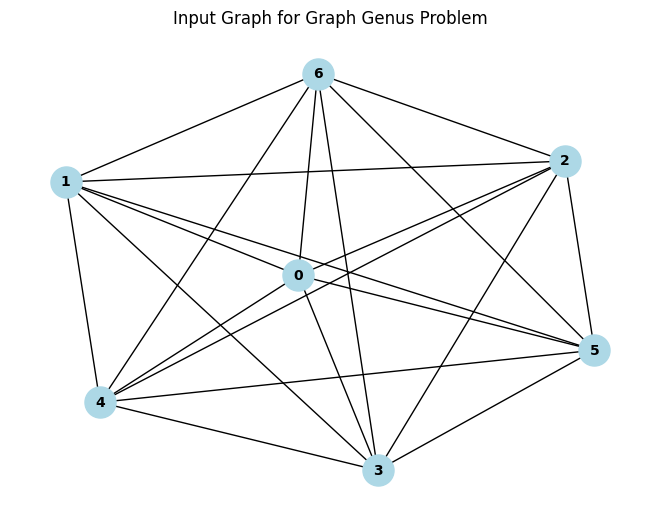

In [57]:
# Get the adjacency list (which is a graph object)
adj_list = problem.adj_list
graph = nx.Graph(adj_list)

def is_power_of_two(n):
    return (n != 0) and (n & (n - 1)) == 0

# Draw the generated graph
nx.draw(graph, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
plt.title("Input Graph for Graph Genus Problem")
plt.show()

In [58]:
# Function to check if a number is a power of two
def is_power_of_two(n):
    return (n & (n - 1) == 0) and n != 0

# Function to get the best result from the CSV file
def get_best_result(file_path):
    df = pd.read_csv(file_path)
    min_fitness = df['Fitness'].min()
    first_min_fitness_index = df[df['Fitness'] == min_fitness].index[0]
    best_result = df.loc[first_min_fitness_index]
    return best_result

# Function to save the best result to a file
def save_best_result(best_result, number_of_nodes, complete_graph, seed, algorithm_name, listed_fitness_over_time, file_path="best_results.csv"):
    data = {
        'Algorithm': [algorithm_name],
        'Number of Nodes': [number_of_nodes],
        'Is Complete': [complete_graph],
        'Final Fitness': [best_result['Fitness']],
        'Plato': [best_result['Iteration']],
        'Time': [best_result['Time']],
        'Seed': [seed],
        'Fitness List': [listed_fitness_over_time],
        'Final State': [best_result['State']]
    }
    df = pd.DataFrame(data)
    # Check if the file exists
    if os.path.exists(file_path):
        # If the file exists, append the new data
        df.to_csv(file_path, mode='a', header=False, index=False)
    else:
        # If the file doesn't exist, create a new one
        df.to_csv(file_path, index=False)

# Generate new seeds from the original seed
def generate_seeds(original_seed, count):
    random.seed(original_seed)
    return [random.randint(0, 1000000) for _ in range(count)]

def get_fitness_over_time(filtered_data, target_length=12):
    fitness_values = filtered_data['Fitness'].tolist()
    if len(fitness_values) >= target_length:
        return fitness_values[:target_length]
    else:
        return fitness_values + [fitness_values[-1]] * (target_length - len(fitness_values))

def random_hill_climb_get_fitness_over_time(iteration_data):
    power = 0
    FitnessList = iteration_data['Fitness'][1:]
    iter_length = len(FitnessList)
    best_fit = FitnessList.iloc[0]  # Access the first element

    best_fit_list = []
    for i in range(iter_length):
        current_fitness = FitnessList.iloc[i]  # Access current fitness value
        if current_fitness < best_fit:
            best_fit = current_fitness
        if i == 2**power:
            best_fit_list.append(best_fit)
            power += 1

    return best_fit_list

# Original seed
new_seeds = generate_seeds(seed, times_to_run)
 # Change this as per the algorithm you are using

for i in range(times_to_run):
    record_file = f"{algorithm_name}_iterations.csv"
    new_seed = new_seeds[i]
    print(new_seed)
    
    #set a random state for the problem each run
    problem.random()

    # Run the algorithm
    match algorithm_name:
        case "Simulated_Annealing":
            final_state, final_fitness, iteration_data = simulated_annealing(problem=problem, schedule=GeomDecay(init_temp=10.0, decay=0.99, min_temp=0.001), max_iters=max_iter, max_attempts=50, random_state=seed, curve=True)
        case "Random_Hill_Climb":
            final_state, final_fitness, iteration_data = random_hill_climb(problem=problem, max_iters=max_iter, restarts=restarts, random_state=seed, record_file=record_file)
        case "Hill_Climb":
            final_fitness, final_state, iteration_data = hill_climb(problem=problem, max_iter=max_iter, seed=seed, record_file=record_file)
        case "Genetic":
            final_fitness, final_state, iteration_data = Genetic_Algorithm(problem=problem, max_attempts=attemps, max_iters=max_iter, restarts=restarts, pop_size=popsize, pop_breed_percent=0.75, elite_dreg_ratio=0.99, minimum_elites=0, minimum_dregs=0, mutation_prob=0.1, record_file=None)
        case _:
            print("algorithm_name undefined")
            break  # Break the loop if the algorithm_name is undefined
    
    # Convert the iteration data to a DataFrame and save to CSV
    df_run_stats = pd.DataFrame(iteration_data)
    df_run_stats.to_csv(record_file, index=False)

    if algorithm_name != "Random_Hill_Climb" and algorithm_name != "Genetic":
        # Filter the data to include only the iterations with iter = to a power of 2 and the last one
        filtered_data = df_run_stats[(df_run_stats['Iteration'] == 0) | 
                             (df_run_stats['Iteration'].apply(is_power_of_two)) | 
                             (df_run_stats['Iteration'] == df_run_stats['Iteration'].max())]
        listed_fitness_over_time = get_fitness_over_time(filtered_data)  
    else:
        listed_fitness_over_time = random_hill_climb_get_fitness_over_time(df_run_stats)

    # Get the best result
    best_result = get_best_result(record_file)
    
    # Save the best result to a summary file
    save_best_result(best_result, number_of_nodes, complete_graph, new_seed, algorithm_name, listed_fitness_over_time, file_path=f"{algorithm_name}_{graph_type}_{number_of_nodes}_Best_Results_Summary.csv")
    
    # Print final results for each run
    print(f"Run {i+1}/{times_to_run}")
    print(listed_fitness_over_time)
    print("Final Fitness:", final_fitness)
    print("Final State:", final_state)
    print("Plato", best_result['Iteration'])


35127
Run 1/10
[4, 4, 4, 4, 4, 4, 4, 4, 4]
Final Fitness: {0: [1, 3, 4, 5, 6, 2], 1: [0, 2, 4, 3, 5, 6], 2: [0, 4, 6, 5, 3, 1], 3: [0, 6, 2, 4, 5, 1], 4: [0, 1, 5, 2, 6, 3], 5: [0, 2, 3, 6, 4, 1], 6: [0, 2, 1, 3, 5, 4]}
Final State: 4
Plato 1
767556
Run 2/10
[4, 4, 4, 4, 4, 4, 4, 4, 4]
Final Fitness: {0: [1, 4, 3, 6, 5, 2], 1: [0, 3, 2, 6, 5, 4], 2: [0, 3, 4, 6, 1, 5], 3: [0, 2, 5, 1, 6, 4], 4: [0, 1, 3, 6, 5, 2], 5: [0, 6, 1, 2, 3, 4], 6: [0, 5, 3, 1, 2, 4]}
Final State: 4
Plato 1
785996
Run 3/10
[4, 4, 4, 4, 4, 4, 4, 4, 4]
Final Fitness: {0: [1, 2, 4, 3, 6, 5], 1: [0, 5, 4, 6, 3, 2], 2: [0, 3, 4, 6, 1, 5], 3: [0, 4, 2, 1, 6, 5], 4: [0, 6, 2, 3, 1, 5], 5: [0, 6, 3, 2, 4, 1], 6: [0, 5, 1, 2, 4, 3]}
Final State: 4
Plato 2
968073
Run 4/10
[4, 4, 4, 4, 4, 4, 4, 4, 4]
Final Fitness: {0: [1, 2, 6, 3, 5, 4], 1: [0, 5, 2, 4, 6, 3], 2: [0, 3, 1, 6, 4, 5], 3: [0, 6, 2, 1, 4, 5], 4: [0, 2, 6, 3, 1, 5], 5: [0, 3, 4, 6, 1, 2], 6: [0, 4, 2, 5, 1, 3]}
Final State: 4
Plato 3
799588
Run 5/10
[5, 4, 4,

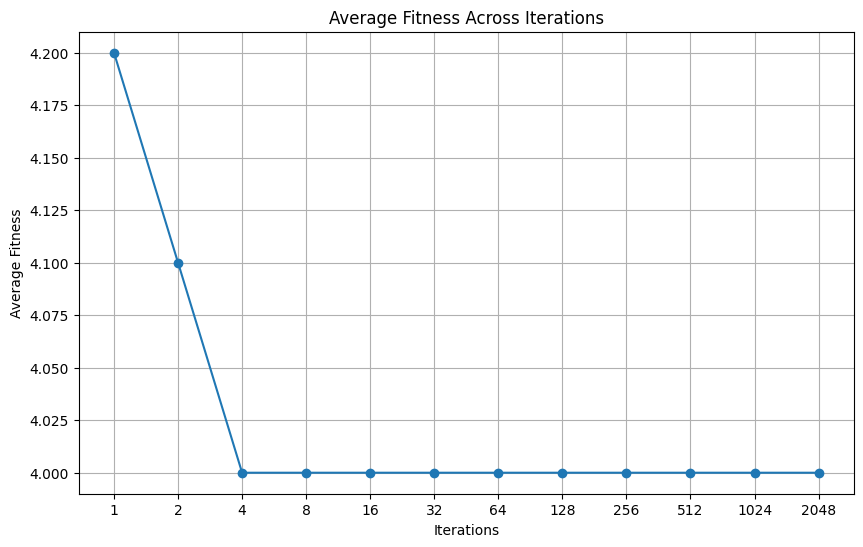

(2.1, 4.0, 4, array([4.2, 4.1, 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. ]))


In [59]:
def average_arrays(array_list):
    """Averages a list of arrays."""
    return np.mean(array_list, axis=0)

def average_plato(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Calculate the average of the "Plato" column
    average_plato_score = df['Plato'].mean()
    average_best_fitness = df['Final Fitness'].mean()
    best_fitness = df['Final Fitness'].min()
    
    # Parse the 'Fitness List' column and ensure each array has length 12
    fitness_over_time_list = df['Fitness List'].apply(ast.literal_eval).apply(lambda x: get_fitness_over_time(pd.DataFrame({'Fitness': x}))).tolist()

    # Calculate the average of the fitness over time if provided
    if fitness_over_time_list:
        average_fitness_over_time = average_arrays(fitness_over_time_list)
    else:
        average_fitness_over_time = None

    pwo2 = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(average_fitness_over_time, marker='o')
    plt.xticks(ticks=range(len(pwo2)), labels=pwo2)
    plt.xlabel('Iterations')
    plt.ylabel('Average Fitness')
    plt.title('Average Fitness Across Iterations')
    plt.grid(True)
    plt.show()

    return average_plato_score, average_best_fitness, best_fitness, average_fitness_over_time


# print(average_plato(f"{algorithm_name}_{graph_type}_5_Best_Results_Summary.csv"))
print(average_plato(f"{algorithm_name}_{graph_type}_{number_of_nodes}_Best_Results_Summary.csv"))



In [60]:
mutation_prob = 0.1
if random.random() < mutation_prob:
    print("yay")